# LSTM을 활용한 주가 예측 모델

이번 튜토리얼 에서는 다음과 같은 **프로세스 파이프라인**으로 주가 예측을 진행합니다.

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- TensorFlow Dataset 클래스를 활용하여 주가 데이터 구축
- LSTM 을 활용한 주가 예측 모델 구축

## 필요한 모듈 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

## 데이터 (FinanceDataReader)

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

**FinanceDataReader**가 아직 설치 되지 않으신 분들은 아래의 주석을 해제한 후 명령어로 설치해 주시기 바랍니다.

In [2]:
 !pip install finance-datareader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.3/89.3 kB 6.3 MB/s eta 0:00:00


In [3]:
import FinanceDataReader as fdr

In [4]:
# 삼성전자(005930) 전체 (1996-11-05 ~ 현재)
samsung = fdr.DataReader('005930')

매우 편리하게 삼성전자 주가 데이터를 `DataFrame`형식으로 받아옵니다.

기본 **오름차순 정렬**이 된 데이터임을 알 수 있습니다.

### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

In [5]:
samsung.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2024-11-13,52000,53000,50500,50600,52527995,-0.045283
2024-11-14,50200,51800,49900,49900,48510715,-0.013834
2024-11-15,50300,54200,50300,53500,46774485,0.072144
2024-11-18,57000,57500,55900,56700,48095234,0.059813
2024-11-19,56500,57500,55900,56300,31436347,-0.007055


**미국 주식 데이터**도 가져올 수 있습니다.

In [ ]:
# Apple(AAPL), 애플
apple = fdr.DataReader('AAPL')

In [ ]:
apple.tail()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2020-12-18,126.65,128.96,129.10,126.12,192540000.0,-0.0159
2020-12-21,128.23,125.03,128.26,123.47,121250000.0,0.0124
2020-12-22,131.88,131.68,134.40,129.66,169350000.0,0.0285
2020-12-23,130.96,132.18,132.32,130.83,88220000.0,-0.0070
2020-12-24,131.99,131.19,133.46,131.10,52790000.0,0.0079


다음과 같이 `2017`을 같이 넘겨주면, 해당 시점 이후의 주식 데이터를 가져옵니다.

In [ ]:
# Apple(AAPL), 애플
apple = fdr.DataReader('AAPL', '2017')

In [ ]:
apple.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2017-01-03,29.04,28.95,29.08,28.69,115130000.0,0.0031
2017-01-04,29.00,28.96,29.13,28.94,84470000.0,-0.0014
2017-01-05,29.15,28.98,29.22,28.95,88770000.0,0.0052
2017-01-06,29.48,29.20,29.54,29.12,127010000.0,0.0113
2017-01-09,29.75,29.49,29.86,29.48,134250000.0,0.0092


**시작**과 **끝** 날짜를 지정하여 범위 데이터를 가져올 수 있습니다.

In [ ]:
# Ford(F), 1980-01-01 ~ 2019-12-30 (40년 데이터)
ford = fdr.DataReader('F', '1980-01-01', '2019-12-30')

In [ ]:
ford.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
1980-03-18,1.85,1.85,1.88,1.84,3770000.0,-0.0160
1980-03-19,1.87,1.87,1.88,1.85,1560000.0,0.0108
1980-03-20,1.88,1.88,1.90,1.87,1450000.0,0.0053
1980-03-21,1.80,1.80,1.87,1.78,5020000.0,-0.0426
1980-03-24,1.73,1.73,1.77,1.68,3330000.0,-0.0389


In [ ]:
ford.tail()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2019-12-23,9.44,9.50,9.57,9.40,54800000.0,-0.0042
2019-12-24,9.47,9.44,9.49,9.43,11880000.0,0.0032
2019-12-26,9.45,9.47,9.49,9.43,28980000.0,-0.0021
2019-12-27,9.36,9.45,9.46,9.35,28270000.0,-0.0095
2019-12-30,9.25,9.34,9.35,9.23,36090000.0,-0.0118


그 밖에 **금, 은과 같은 현물**, **달러와 같은 화폐** 데이터도 가져올 수 있습니다.

더욱 자세한 내용은 [GitHub 페이지 링크](https://github.com/FinanceData/FinanceDataReader)를 참고해 보시기 바랍니다.

In [ ]:
## 주가데이터 가져오기

지난 주식 예측 튜토리얼에서는 **삼성전자** 주가데이터로 실습을 해봤으니,

이번에는 글로벌 증시의 대장주인 **Apple**사의 주가데이터를 가져와서 예측해 보도록 하겠습니다.

In [6]:
# 삼성전자 주식코드: 005930
STOCK_CODE = '005930'

In [7]:
stock = fdr.DataReader(STOCK_CODE)

In [8]:
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2000-07-28,5800,5910,5710,5730,1660739,NaN
2000-07-31,5730,5910,5550,5900,932312,0.029668
2000-08-01,5960,6270,5870,6220,1062466,0.054237
2000-08-02,6100,6170,5930,6070,743825,-0.024116
2000-08-03,6180,6180,5970,6030,556342,-0.006590


In [9]:
stock.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2024-11-13,52000,53000,50500,50600,52527995,-0.045283
2024-11-14,50200,51800,49900,49900,48510715,-0.013834
2024-11-15,50300,54200,50300,53500,46774485,0.072144
2024-11-18,57000,57500,55900,56700,48095234,0.059813
2024-11-19,56500,57500,55900,56300,31436347,-0.007055


In [10]:
stock.index

DatetimeIndex(['2000-07-28', '2000-07-31', '2000-08-01', '2000-08-02',
               '2000-08-03', '2000-08-04', '2000-08-07', '2000-08-08',
               '2000-08-09', '2000-08-10',
               ...
               '2024-11-06', '2024-11-07', '2024-11-08', '2024-11-11',
               '2024-11-12', '2024-11-13', '2024-11-14', '2024-11-15',
               '2024-11-18', '2024-11-19'],
              dtype='datetime64[ns]', name='Date', length=6000, freq=None)

위에서 보시는 바와 같이 index가 `DatetimeIndex`로 지정되어 있습니다.

`DatetimeIndex`로 정의되어 있다면, 아래와 같이 연도, 월, 일을 쪼갤 수 있으며, **월별, 연도별 피벗데이터**를 만들때 유용하게 활용할 수 있습니다.

In [11]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

In [12]:
stock.head()

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
2000-07-28,5800,5910,5710,5730,1660739,NaN,2000,7,28
2000-07-31,5730,5910,5550,5900,932312,0.029668,2000,7,31
2000-08-01,5960,6270,5870,6220,1062466,0.054237,2000,8,1
2000-08-02,6100,6170,5930,6070,743825,-0.024116,2000,8,2
2000-08-03,6180,6180,5970,6030,556342,-0.006590,2000,8,3


## 시각화

Text(0, 0.5, 'price')

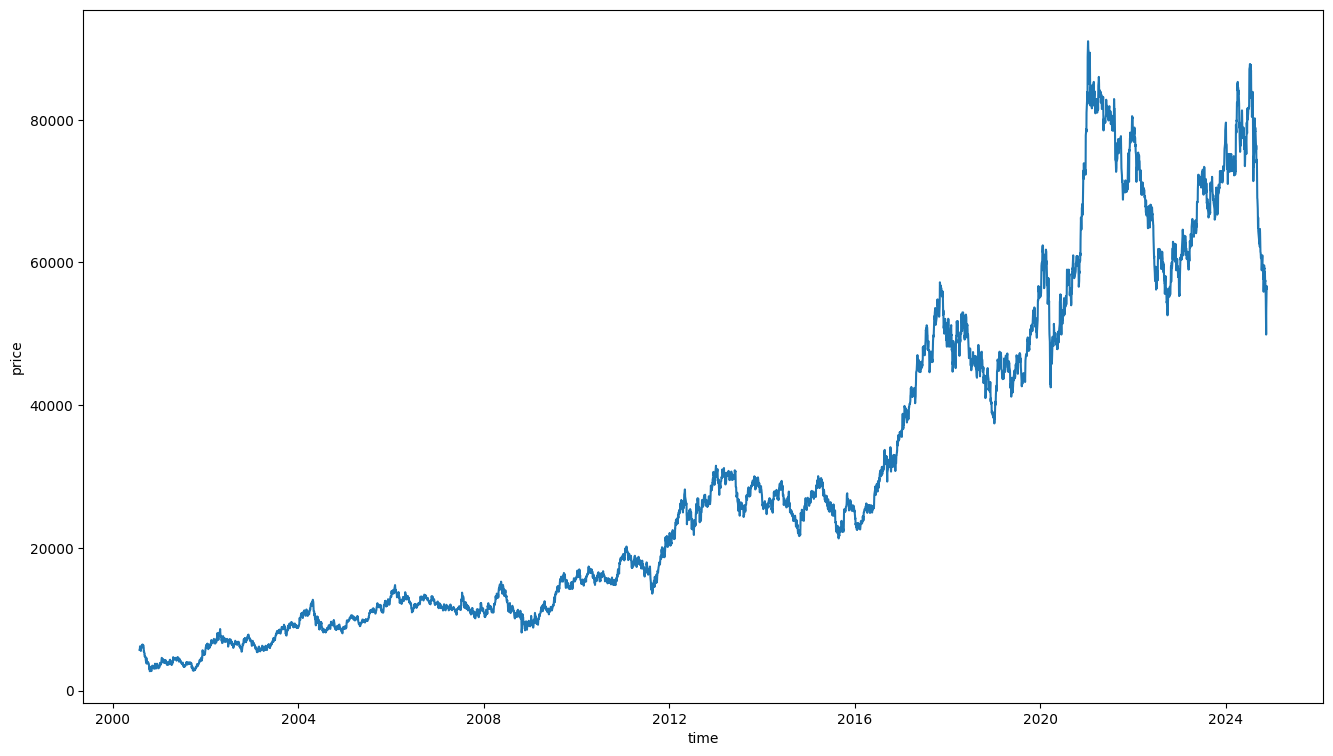

In [13]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

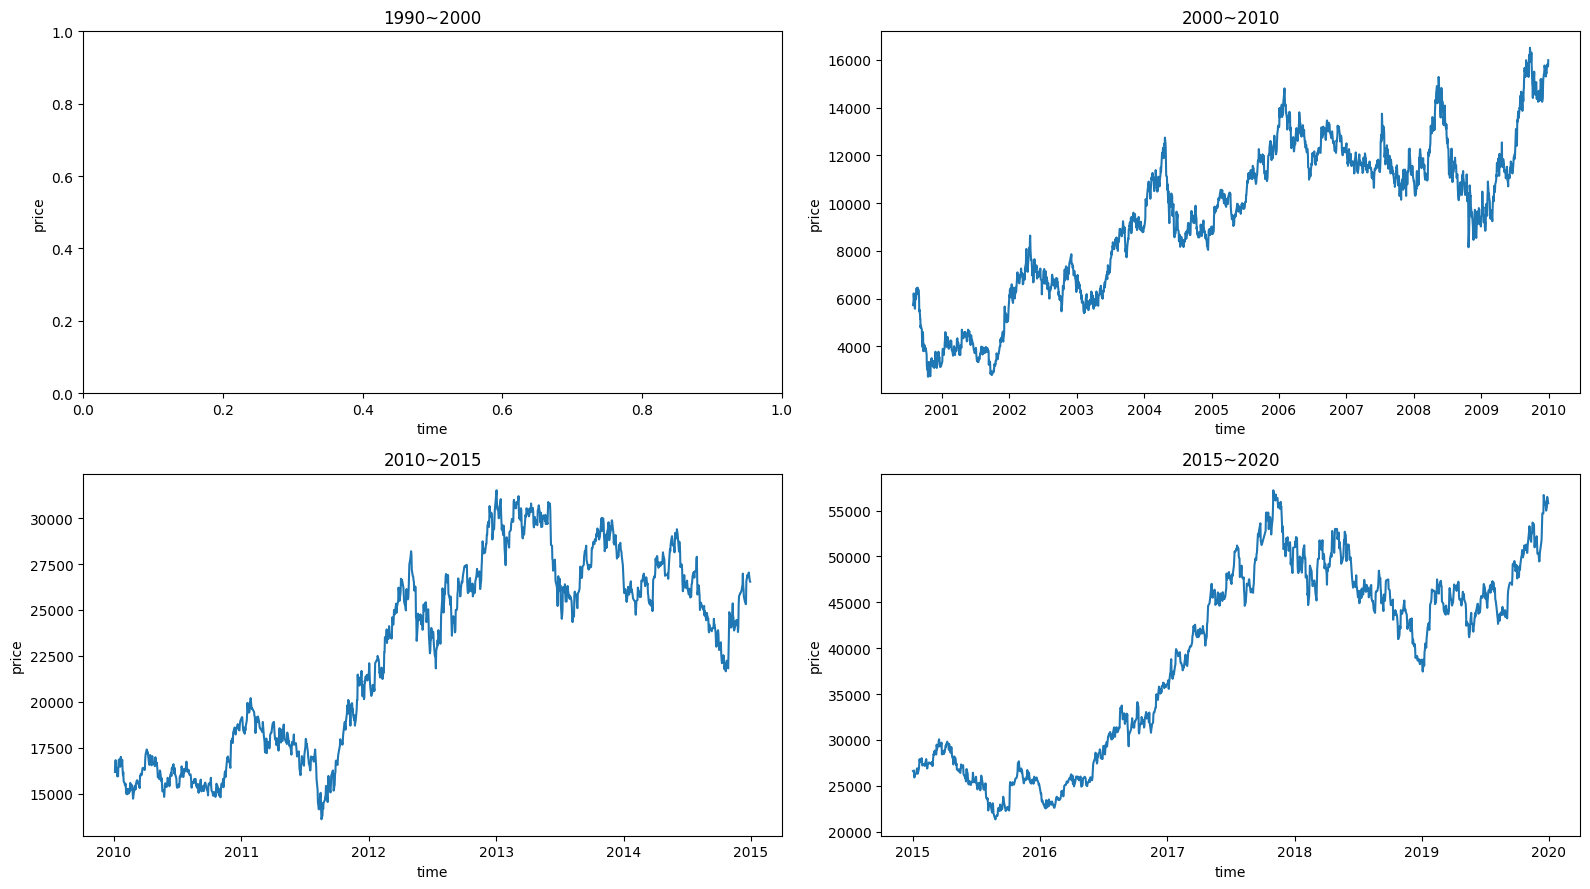

In [14]:
time_steps = [['1990', '2000'],
              ['2000', '2010'],
              ['2010', '2015'],
              ['2015', '2020']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

## 데이터 전처리

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[0.06423034, 0.06105372, 0.06379888, 0.03398663, 0.01839009],
       [0.06345515, 0.06105372, 0.06201117, 0.03591254, 0.0103239 ],
       [0.06600221, 0.06477273, 0.06558659, 0.03953778, 0.01176515],
       ...,
       [0.55703212, 0.55991736, 0.56201117, 0.5751671 , 0.51795444],
       [0.63122924, 0.59400826, 0.62458101, 0.61141951, 0.53257967],
       [0.62569214, 0.59400826, 0.62458101, 0.60688796, 0.34810849]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외했습니다.

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [16]:
df = pd.DataFrame(scaled, columns=scale_cols)

## train / test 분할

In [17]:
from sklearn.model_selection import train_test_split

In [19]:
# x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', axis=1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [20]:
x_train.shape, y_train.shape

((4800, 4), (4800,))

In [21]:
x_test.shape, y_test.shape

((1200, 4), (1200,))

In [22]:
x_train

,Open,High,Low,Volume
0,0.064230,0.061054,0.063799,0.018390
1,0.063455,0.061054,0.062011,0.010324
2,0.066002,0.064773,0.065587,0.011765
3,0.067553,0.063740,0.066257,0.008237
4,0.068439,0.063843,0.066704,0.006161
...,...,...,...,...
4795,0.616833,0.587810,0.620112,0.136348
4796,0.622370,0.584711,0.622346,0.092538
4797,0.614618,0.578512,0.614525,0.143880
4798,0.620155,0.584711,0.613408,0.170777


## TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성

In [23]:
import tensorflow as tf

In [24]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Hyperparameter를 정의합니다.

In [25]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [26]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [27]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


## 모델

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [29]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [32]:
# # earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
# earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# # val_loss 기준 체크포인터도 생성합니다.
# filename = os.path.join('tmp', 'ckeckpointer.ckpt')
# checkpoint = ModelCheckpoint(filename,
#                              save_weights_only=True,
#                              save_best_only=True,
#                              monitor='val_loss',
#                              verbose=1)
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt.weights.h5') # .weights.h5를 추가합니다.
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

In [33]:
history = model.fit(train_data,
                    validation_data=(test_data),
                    epochs=50,
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    150/Unknown 7s 7ms/step - loss: 6.5261e-04 - mse: 0.0013
Epoch 1: val_loss improved from inf to 0.00354, saving model to tmp/ckeckpointer.ckpt.weights.h5
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 6.5038e-04 - mse: 0.0013 - val_loss: 0.0035 - val_mse: 0.0071
Epoch 2/50
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5366e-05 - mse: 5.0733e-05
Epoch 2: val_loss improved from 0.00354 to 0.00219, saving model to tmp/ckeckpointer.ckpt.weights.h5
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.5913e-05 - mse: 5.1827e-05 - val_loss: 0.0022 - val_mse: 0.0044
Epoch 3/50
143/150 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.0455e-05 - mse: 4.0910e-05
Epoch 3: val_loss improved from 0.00219 to 0.00134, saving model to tmp/ckeckpointer.ckpt.weights.h5
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.1959e-05 - mse: 4.3918e-05 - val_loss: 0.0013 - val_mse: 0.0027
Epoch 4/50
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.1992e-05 - mse: 4.3984e-05
Epoch 4: val_loss di

저장한 ModelCheckpoint 를 로드합니다.

In [34]:
model.load_weights(filename)

`test_data`를 활용하여 예측을 진행합니다.

In [35]:
pred = model.predict(test_data)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [36]:
pred.shape

(1180, 1)

## 예측 데이터 시각화

아래 시각화 코드중 y_test 데이터에 **[20:]**으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 *앞의 20일은 예측하지 않습니다.*

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

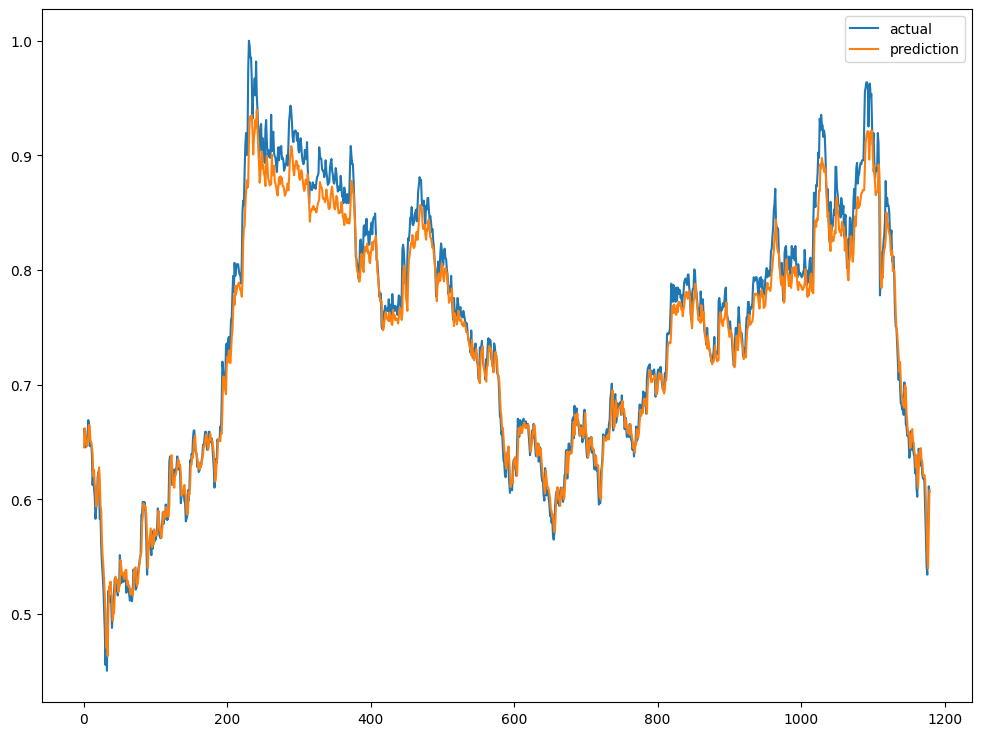

In [37]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()